## **Content Based Recommenders**


In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "Data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_path + "movielens_10m.zip")

URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = data_file_path + "decompressed/")

URM_file = open(URM_path, 'r')

In [2]:
import pandas as pd

URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep="::", 
                                header=None, 
                                dtype={0:int, 1:int, 2:float, 3:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

In [3]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


## And now load the content informations in the same way:
## In this case we are using tags. The ICM also contains the user that added the tag in column 0 (but we don't use that information).

In [4]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = data_file_path + "decompressed/")

ICM_dataframe = pd.read_csv(filepath_or_buffer=ICM_path, 
                            sep="::", 
                            header=None, 
                            dtype={0:int, 1:int, 2:str, 3:int},
                            engine='python')

ICM_dataframe.columns = ["UserID", "ItemID", "FeatureID", "Timestamp"]

In [5]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835
5,20,2424,ryan,1188263835
6,20,2947,action,1188263755
7,20,2947,bond,1188263756
8,20,3033,spoof,1188263880
9,20,3033,star wars,1188263880


### We can see that most users and items have no data associated to them

In [6]:
n_features = len(ICM_dataframe["FeatureID"].unique())

print ("Number of tags\t {}, Number of item-tag tuples {}".format(n_features, len(ICM_dataframe)))

Number of tags	 16529, Number of item-tag tuples 95580


## We now build the sparse URM and ICM matrices

### The tags are strings, we should traslate them into numbers so we can use them as indices in the ICM.
### We should also ensure that the item and user indices we use in ICM and URM are consistent. To do so we use the same mapper, first we populate it with the URM and then we add the new ids that appear only in the ICM

In [7]:
user_original_ID_to_index_dict = {}

for user_id in URM_all_dataframe["UserID"].unique():
    user_original_ID_to_index_dict[user_id] = len(user_original_ID_to_index_dict)  

print("Unique user_id in the URM are {}".format(len(user_original_ID_to_index_dict)))
    
for user_id in ICM_dataframe["UserID"].unique():
    if user_id not in user_original_ID_to_index_dict:
        user_original_ID_to_index_dict[user_id] = len(user_original_ID_to_index_dict)
        
print("Unique user_id in the URM and ICM are {}".format(len(user_original_ID_to_index_dict)))

Unique user_id in the URM are 69878
Unique user_id in the URM and ICM are 71567


In [8]:
item_original_ID_to_index_dict = {}

for item_id in URM_all_dataframe["ItemID"].unique():
    item_original_ID_to_index_dict[item_id] = len(item_original_ID_to_index_dict)

print("Unique item_id in the URM are {}".format(len(item_original_ID_to_index_dict)))
    
for item_id in ICM_dataframe["ItemID"].unique():
    if item_id not in item_original_ID_to_index_dict:
        item_original_ID_to_index_dict[item_id] = len(item_original_ID_to_index_dict)
        
print("Unique item_id in the URM and ICM are {}".format(len(item_original_ID_to_index_dict)))

Unique item_id in the URM are 10677
Unique item_id in the URM and ICM are 10681


In [9]:
feature_original_ID_to_index_dict = {}

for feature_id in ICM_dataframe["FeatureID"].unique():
    feature_original_ID_to_index_dict[feature_id] = len(feature_original_ID_to_index_dict)

print("Unique feature_id in the URM are {}".format(len(feature_original_ID_to_index_dict)))

Unique feature_id in the URM are 16529


In [10]:
original_feature_ID = "star wars"
print("New index for feature '{}' is {}".format(original_feature_ID, feature_original_ID_to_index_dict[original_feature_ID]))

New index for feature 'star wars' is 9


# We can now build the URM and ICM using the new indices


In [11]:
URM_all_dataframe["UserID"] = [user_original_ID_to_index_dict[user_original] for user_original in
                                      URM_all_dataframe["UserID"].values]

URM_all_dataframe["ItemID"] = [item_original_ID_to_index_dict[item_original] for item_original in 
                                      URM_all_dataframe["ItemID"].values]

In [12]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [13]:
ICM_dataframe["UserID"] = [user_original_ID_to_index_dict[user_original] for user_original in
                                      ICM_dataframe["UserID"].values]

ICM_dataframe["ItemID"] = [item_original_ID_to_index_dict[item_original] for item_original in 
                                      ICM_dataframe["ItemID"].values]

ICM_dataframe["FeatureID"] = [feature_original_ID_to_index_dict[feature_original] for feature_original in 
                                      ICM_dataframe["FeatureID"].values]

In [14]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,69878,1926,0,1215184630
1,69879,1040,1,1188263867
2,69879,1040,2,1188263867
3,69879,1086,3,1188263835
4,69879,1086,4,1188263835
5,69879,1086,5,1188263835
6,69879,612,6,1188263755
7,69879,612,7,1188263756
8,69879,628,8,1188263880
9,69879,628,9,1188263880


### When we create the matrices we need to make sure they have the same shape. As we have seen some items and users only appear in one of the two matrices and are missing in the other (if they have no tags or no interactions)

In [15]:
import scipy.sparse as sps
import numpy as np

n_users = len(user_original_ID_to_index_dict)
n_items = len(item_original_ID_to_index_dict)
n_features = len(feature_original_ID_to_index_dict)

In [16]:
URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<71567x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

In [17]:
ICM_all = sps.csr_matrix((np.ones(len(ICM_dataframe["ItemID"].values)), 
                          (ICM_dataframe["ItemID"].values, ICM_dataframe["FeatureID"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all

<10681x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [18]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [19]:
print(features_per_item.shape)
print(items_per_feature.shape)

(10681,)
(16529,)


In [20]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

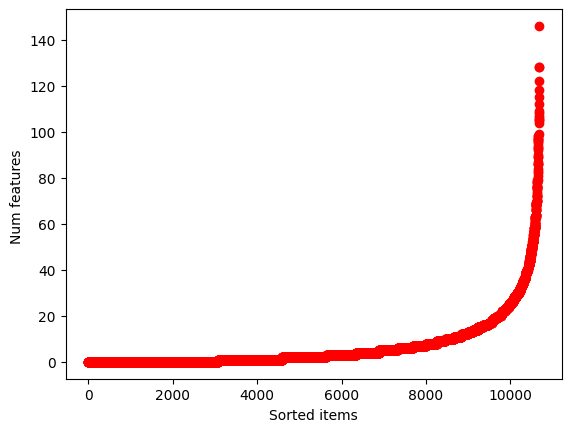

In [21]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

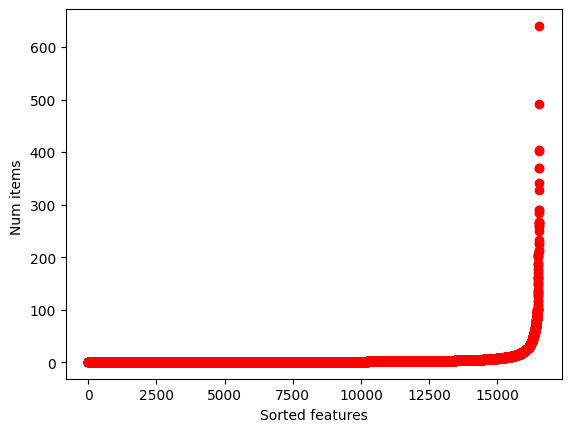

In [22]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [23]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


EvaluatorHoldout: Ignoring 1926 ( 2.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1782 ( 2.5%) Users that have less than 1 test interactions


### We need to define Cosine similarity... Let's look at the attached source code

### See also a [list of commonly used KNN similarity heuristics](https://github.com/MaurizioFD/RecSys_Course_2018/blob/master/slides/List_of_KNN_similarity_heuristics.pdf)

## A KNN is built with the following steps:
* Compute the similarity of an item with all others
* Select the k-highest similarities

In [24]:
item_id = 80
shrink = 10

The numerator is the dot product of the item features times the whole ICM data transposed

In [25]:
numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
numerator_vector

array([2., 0., 0., ..., 0., 1., 0.])

In [26]:
item_norms = np.sqrt(np.array(ICM_all.T.power(2).sum(axis=0))).ravel()
item_norms

array([1.73205081, 4.35889894, 5.29150262, ..., 1.        , 1.41421356,
       1.41421356])

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

In [27]:
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6
denominator_vector

array([15.47722658, 23.78404975, 26.73320153, ..., 13.16227866,
       14.47213695, 14.47213695])

In [28]:
similarity_vector = numerator_vector/denominator_vector

Let's sort the similarity from the highest to the lowest

In [29]:
sorted_item_indices = np.argsort(-similarity_vector)
sorted_item_indices

array([   80,  3542,     0, ...,  3938,  3931, 10680], dtype=int64)

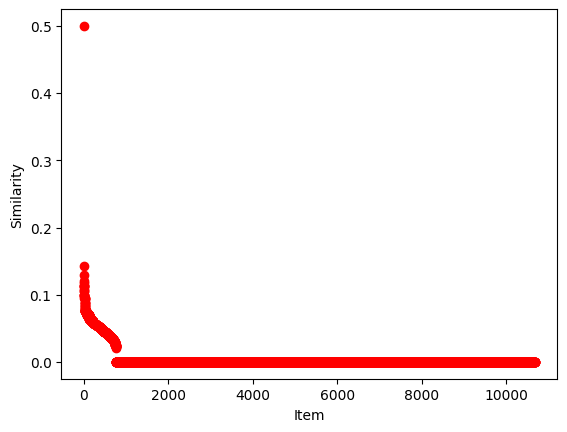

In [30]:
pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

Now we select the k most similar items

In [31]:
k = 100

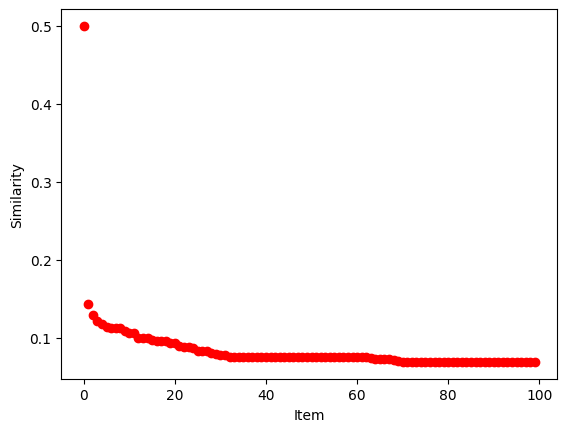

In [32]:
pyplot.plot(similarity_vector[sorted_item_indices[0:k]], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

In [33]:
import traceback

try:
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
except Exception as e:
    traceback.print_exc()
    

The solution is:
* Compute the numerator a block of items at a time leveraging vectorization while not running out of memory
* Extract the k-nn on those items
* Built incrementally the sparse similarity matrix

In [34]:
block_size = 100

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
numerator_block.shape

(100, 10681)

Let's compare the speed to compute the dot product on the whole similarity of the two strategies

In [35]:
import time

n_items = ICM_all.shape[0]

start_time = time.time()

for n_item in range(n_items):
    numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
    
end_time = time.time()

print("Computing the similarity one item at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity one item at a time runs at 1311.34 items/sec


In [36]:
n_items = ICM_all.shape[0]

start_time = time.time()

block_size = 100
blocks_start_positions = range(0, n_items, block_size)

for start_pos in blocks_start_positions:
    end_pos = min(start_pos + block_size, n_items)
    
    numerator_block = ICM_all[start_pos:end_pos].dot(ICM_all.T).toarray()
    
end_time = time.time()

print("Computing the similarity in blocks of 100 items at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity in blocks of 100 items at a time runs at 27175.14 items/sec


### In this case the vectorized implementation runs >20 times faster!

#### Usually most of the speed gain comes with blocks of 100 or so items, depending on the system. Much higher than that tends to not be beneficial while requiring increasingly more memory.

Now an example of something you should *never* do, nested loops to compute the similarity of each item without vectorization

In [37]:
n_items = 100

start_time = time.time()

for n_item in range(n_items):
    for second_item in range(n_items):
        numerator_vector = ICM_all[item_id].dot(ICM_all[second_item].T)
    
end_time = time.time()

print("Computing the similarity with nested loops runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity with nested loops runs at 33.21 items/sec


You see how incredibly slow nested loops are compared to a well vectorized implementation

#### Let's now compute the entire similarity matrix and use it to generate recommendations

In [38]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(ICM_all.T, shrink=0.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 10681 (100.0%), 4359.74 column/sec. Elapsed time 2.45 sec


<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 624111 stored elements in Compressed Sparse Row format>

In [39]:
user_id = 200
user_profile = URM_train[user_id]

scores = user_profile.dot(W_sparse)
scores

<1x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 5523 stored elements in Compressed Sparse Row format>

In [40]:
scores = scores.toarray().ravel()
scores

array([3.77329066, 4.59290504, 7.53792299, ..., 0.        , 2.99999857,
       0.        ])

We can then sort the scores to recommend the highest ranked ones

In [41]:
ranking = scores.argsort()[::-1][0:10]
ranking

array([2643, 2644,  436,  235,  177, 3589, 5058, 3562, 3584, 8533],
      dtype=int64)

In [42]:
scores[ranking]

array([25.04195338, 20.42638889, 19.85643119, 19.59445615, 19.41101268,
       19.29249585, 19.29249585, 19.29249585, 19.29249585, 19.29249585])

## Test our CBF recommender:

#### We put everything in a Python class with a standard interface

In [43]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [44]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 (100.0%), 4818.76 column/sec. Elapsed time 2.22 sec


In [45]:
for user_id in range(10):
    print(recommender.recommend(user_id, at=5))

[  18 4759  554 1427  851]
[177 196  24 401 822]
[5664 5660   60  798 2813]
[1723  441 1331 2088 5106]
[1184 2146  148 1122  220]
[ 37  24 133 235  19]
[ 220  164  249  149 1441]
[1234  968 2065 2093 2952]
[585 616 788 411 170]
[1310   16   57   34  797]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [46]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 976.11 usr/sec


### Let's add a common mistake.... a CSC URM

In [47]:
URM_train_csc = URM_train.tocsc()

recommender = ItemKNNCBFRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 (100.0%), 4754.31 column/sec. Elapsed time 2.25 sec


In [48]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()


Exception index 10683 is out of bounds for axis 0 with size 10681


Traceback (most recent call last):
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_50820\1484869668.py", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_50820\4145966258.py", line 25, in recommend
    scores = self.filter_seen(user_id, scores)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_50820\4145966258.py", line 40, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 10683 is out of bounds for axis 0 with size 10681


## Hyperparameter tuning

#### Once we have built our model we can play with its hyperparameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [49]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 75 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 5221.12 column/sec. Elapsed time 2.05 sec
EvaluatorHoldout: Processed 69785 (100.0%) in 33.94 sec. Users per second: 2056
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 75 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 4455.97 column/sec. Elapsed time 2.40 sec
EvaluatorHoldout: Processed 69785 (100.0%) in 37.98 sec. Users per second: 1837
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 7

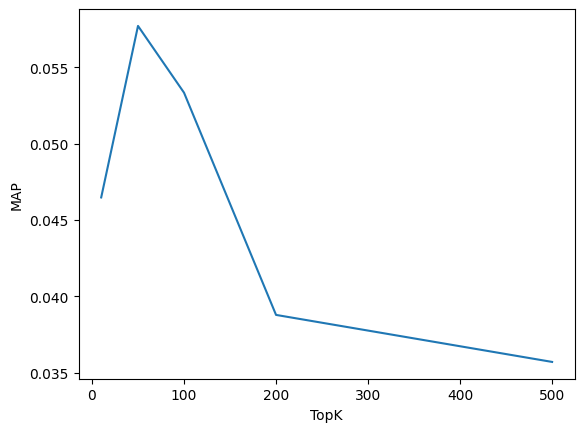

In [50]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors has a limited impact on MAP. Fine-tuning around the best values is needed.

#### Different datasets will behave in different ways.

### Shrinkage

In [51]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 75 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 4301.91 column/sec. Elapsed time 2.48 sec
EvaluatorHoldout: Processed 69785 (100.0%) in 41.28 sec. Users per second: 1690
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 75 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 4043.45 column/sec. Elapsed time 2.64 sec
EvaluatorHoldout: Processed 69785 (100.0%) in 40.71 sec. Users per second: 1714
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 7

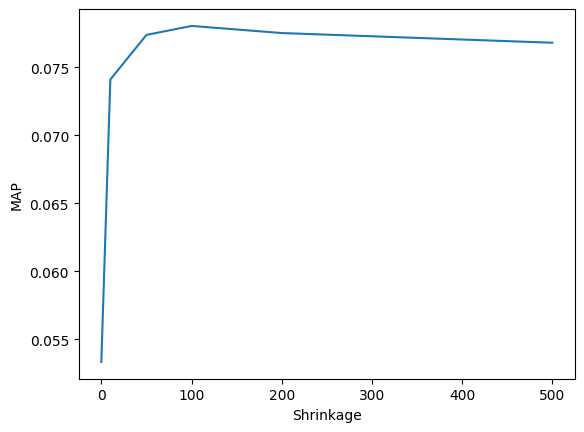

In [52]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [53]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(sps.csc_matrix(ICM_all).indptr)

IDF = np.log(num_tot_items / items_per_feature)

print(ICM_all.shape)
print(IDF.shape)

(10681, 16529)
(16529,)


In [54]:
np.sort(items_per_feature)

array([  1,   1,   1, ..., 404, 492, 640], dtype=int32)

In [55]:
np.sort(IDF)

array([2.81475356, 3.07774302, 3.27480686, ..., 9.27622174, 9.27622174,
       9.27622174])

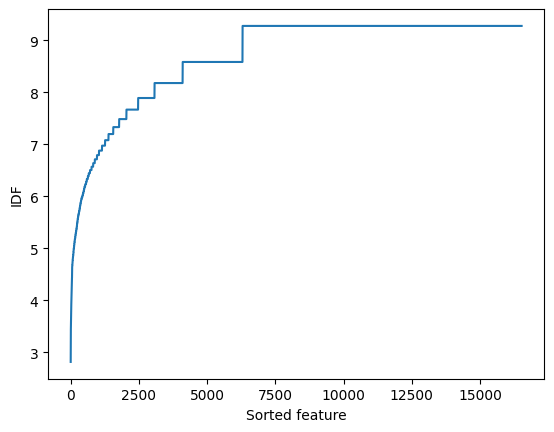

In [56]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

#### Highest ranked features

In [57]:
feature_index_to_original_ID_dict = {value:key for key,value in feature_original_ID_to_index_dict.items()}

In [58]:
sorted_features = np.argsort(-IDF)

highest_ranked_features = sorted_features[:20]

for feature_index in highest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])

Tour de France
Parkour: Getting Around Obstacles A Great Complement To Being Alive
I Guess Nude Terminators Can't Kill A Really Bad Film
The Whole Tromeo & Juliet Threw Me Off But Thank Gawd They Didn't Talk Like Bill The Spear Shaker
What If The Big Bad Wolf & Grandma Were Swapping Spit?
An Orifice & A Gentle Hand Refried For '06
Read All The Negative Reviews & Save 2 Hours Of Your Life!
'Lemme Get This Straight. You Have No Idea Who You Are But You Wanna Be Famous?'
If I See One More Roast Beef Sandwich You Will Smell My Reaction
Obviously Hillary Had A Different Meaning For "Secret Service"
Ethan Hunt Should Stop Hogging The Screen!
'Priceline Negotiator!'
The Power Of The P
Believe In Your Ability To See Stoopid Plotlines
Not Even Uma Could Save This Dizaster! Wanda Yikes!
It's Not Size Of Your Stick But Why You Keep On Swingin' It!
'So How Did Lois Survive Date Nite?'
A Comedy Version Of Matchpoint
You Would Do Anything In The Universe To Get Rachael Weisz Back As Well
Or How The 

#### Lowest ranked features

In [59]:
lowest_ranked_features = sorted_features[-20:]

for feature_index in lowest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])    

atmospheric
library
seen more than once
Nudity (Topless - Brief)
To See
adapted from:book
imdb top 250
Can't remember
classic
Bibliothek
Betamax
National Film Registry
movie to see
Nudity (Topless)
based on a book
70mm
R
erlend's DVDs
less than 300 ratings
Tumey's DVDs


In [60]:
from scipy.sparse import diags
diags(IDF)

<16529x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 16529 stored elements (1 diagonals) in DIAgonal format>

In [61]:
ICM_idf = ICM_all.copy()

ICM_idf = ICM_idf*diags(IDF)

In [62]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 75 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 7535.72 column/sec. Elapsed time 1.42 sec
EvaluatorHoldout: Processed 69785 (100.0%) in 37.85 sec. Users per second: 1844


PRECISION                     0.064581
PRECISION_RECALL_MIN_DEN      0.069599
RECALL                        0.031548
MAP                           0.032934
MAP_MIN_DEN                   0.035178
MRR                           0.181946
NDCG                          0.061869
F1                            0.042389
HIT_RATE                      0.360765
ARHR_ALL_HITS                 0.241879
NOVELTY                       0.012852
AVERAGE_POPULARITY            0.146346
DIVERSITY_MEAN_INTER_LIST     0.974687
DIVERSITY_HERFINDAHL          0.997467
COVERAGE_ITEM                 0.496864
COVERAGE_ITEM_HIT             0.119558
ITEMS_IN_GT                   0.959835
COVERAGE_USER                   0.9751
COVERAGE_USER_HIT             0.351782
USERS_IN_GT                     0.9751
DIVERSITY_GINI                0.086194
SHANNON_ENTROPY               9.981998
RATIO_DIVERSITY_HERFINDAHL     0.99822
RATIO_DIVERSITY_GINI          0.442793
RATIO_SHANNON_ENTROPY         0.881453
RATIO_AVERAGE_POPULARITY 

#### Try other feature weighting methods like BM25...

# BM25

In [63]:
from Recommenders.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [64]:
recommender_bm25 = ItemKNNCBFRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_bm25)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 75 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 10681 (100.0%), 4795.69 column/sec. Elapsed time 2.23 sec
EvaluatorHoldout: Processed 69785 (100.0%) in 38.43 sec. Users per second: 1816


PRECISION                     0.068437
PRECISION_RECALL_MIN_DEN      0.073709
RECALL                         0.03331
MAP                            0.03511
MAP_MIN_DEN                   0.037474
MRR                           0.190552
NDCG                          0.065515
F1                             0.04481
HIT_RATE                      0.375195
ARHR_ALL_HITS                  0.25534
NOVELTY                       0.012719
AVERAGE_POPULARITY            0.157677
DIVERSITY_MEAN_INTER_LIST     0.973124
DIVERSITY_HERFINDAHL          0.997311
COVERAGE_ITEM                 0.498174
COVERAGE_ITEM_HIT             0.120962
ITEMS_IN_GT                   0.959835
COVERAGE_USER                   0.9751
COVERAGE_USER_HIT             0.365853
USERS_IN_GT                     0.9751
DIVERSITY_GINI                0.084211
SHANNON_ENTROPY               9.928453
RATIO_DIVERSITY_HERFINDAHL    0.998064
RATIO_DIVERSITY_GINI          0.432608
RATIO_SHANNON_ENTROPY         0.876724
RATIO_AVERAGE_POPULARITY 

#### A small gain over TF-IDF

# Unnormalized similarity matrix

In [65]:
recommender_dot = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

result_df, _ = evaluator_test.evaluateRecommender(recommender_dot)
result_df.loc[10]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 75 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
EvaluatorHoldout: Processed 69785 (100.0%) in 1.05 min. Users per second: 1107


PRECISION                     0.123802
PRECISION_RECALL_MIN_DEN       0.13431
RECALL                        0.060202
MAP                            0.06839
MAP_MIN_DEN                    0.07331
MRR                           0.327221
NDCG                          0.130527
F1                             0.08101
HIT_RATE                      0.585971
ARHR_ALL_HITS                 0.462738
NOVELTY                       0.008519
AVERAGE_POPULARITY            0.583097
DIVERSITY_MEAN_INTER_LIST     0.599587
DIVERSITY_HERFINDAHL          0.959958
COVERAGE_ITEM                 0.045033
COVERAGE_ITEM_HIT             0.018725
ITEMS_IN_GT                   0.959835
COVERAGE_USER                   0.9751
COVERAGE_USER_HIT             0.571381
USERS_IN_GT                     0.9751
DIVERSITY_GINI                0.002439
SHANNON_ENTROPY               5.047723
RATIO_DIVERSITY_HERFINDAHL    0.960683
RATIO_DIVERSITY_GINI           0.01253
RATIO_SHANNON_ENTROPY         0.445735
RATIO_AVERAGE_POPULARITY 